In [1]:
import pickle
import os
from collections import Counter
from typing import List


import numpy as np
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm


from numpy_nn.modules.np_nn import (
    FullyConnectedLayer,
    ReLULayer,
    SigmoidLayer,
    ReLULayer,
    AdamOptimizer,
    CrossEntropyLoss,
    LinearActivation,
    Sequential,
    Optimizer,
    SoftMaxLayer,
    GradientDescentOptimizer,
    CrossEntropyLossWithSoftMax,
    softmax,
    Conv2d,
    Flatten,
    BatchNormalization2d,
)

# from numpy_nn.models.resnet_without_batchnorm import resnet101

from numpy_nn.models.resnet import resnet101

from utils.plot import plot_history

plt.gray()

<Figure size 640x480 with 0 Axes>

In [41]:
np.random.seed(0)

In [42]:
def one_hot(y: np.ndarray, n_classes: int):
    encoded = np.zeros((y.size, n_classes))
    encoded[np.arange(y.size), y] = 1
    return encoded

def padding(X, pad):
    batch_size, channels, h, w = X.shape
    out = np.zeros((batch_size, channels, h + 2 * pad, w + 2 * pad))
    out[:, :, pad:pad + h, pad:pad + w] = X
    return out

In [43]:
((X_train, y_train), (X_test, y_test)) = mnist.load_data()

In [44]:
y_train_value_counts = Counter(y_train)
y_test_value_counts = Counter(y_test)

for key in range(10):
    print(f"{key}: {y_train_value_counts[key]}", end = ' ')
print()
for key in range(10):
    print(f"{key}: {y_test_value_counts[key]}", end = ' ')

0: 5923 1: 6742 2: 5958 3: 6131 4: 5842 5: 5421 6: 5918 7: 6265 8: 5851 9: 5949 
0: 980 1: 1135 2: 1032 3: 1010 4: 982 5: 892 6: 958 7: 1028 8: 974 9: 1009 

Padding is used beacause it's supposed to use resnet on images that have a shape that is multiple of 32

In [45]:
X_train = padding(X_train.reshape(-1, 1, 28, 28), 2).astype(np.float32)
X_test = padding(X_test.reshape(-1, 1, 28, 28), 2).astype(np.float32)
y_train = one_hot(y_train, 10)
y_test = one_hot(y_test, 10)

In [46]:
y_train.shape, X_train.shape

((60000, 10), (60000, 1, 32, 32))

In [47]:
X_train = X_train/255
X_test = X_test/255

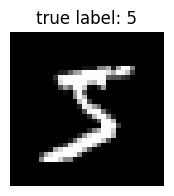

In [48]:
def plot_mnist_example(X, y, i):
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.title(f"true label: {np.argmax(y[i])}")
    plt.imshow(X[i].reshape(32, 32))
    plt.show()

plot_mnist_example(X_train, y_train, 0)

In [49]:
# Decided that probably torch follows the best initialization
# practices which may lead to better performance

def get_model_initialized_with_torch(seed: int = 0):
    model = resnet101(10, 1)
    
    from pytorch_nn.models.resnet import resnet101 as resnet101_torch

    import torch

    torch.manual_seed(seed)

    torch_resnet = resnet101_torch(10, 1)

    model.clone_weights_from_torch(torch_resnet)
    
    return model

In [50]:
seed = 0
a = get_model_initialized_with_torch(seed)
b = get_model_initialized_with_torch(seed)

In [51]:
a.is_equal(b)

True

In [52]:
# Saving optimizer and model in one structure is crucial because they share same
# "trainable_layers" list. Otherwise after loading those will be two separate lists.
# Ofcourse this problem could be fixed just be assigning one list to another.
# But incapsulation is safer and the file will
# weight less (abput 2 times less) then three separate files.
def save_model_optimizer_history(model,
                                 optimizer,
                                 epoch_history,
                                 file_name,
                                 model_info: str = None):
    model_optimizer_history_dict = {
        "model": model,
        "optimizer": optimizer,
        "epoch_history": epoch_history,
        "model_info": model_info,
    }
    with open(file_name, 'wb') as f:
        pickle.dump(model_optimizer_history_dict, f)


def load_model_optimizer_history(file_name):
    with open(file_name, 'rb') as f:
        model_optimizer_history_dict = pickle.load(f)
    
    return (model_optimizer_history_dict["model"], 
            model_optimizer_history_dict["optimizer"],
            model_optimizer_history_dict["epoch_history"])

In [53]:
weights_dir = os.path.join("numpy_nn", "models", "trained_models", "resnet101")

model_optim_history_filename = os.path.join(weights_dir, r"model_optimizer_history_dict.pickle")

model_init_seed = 0


loss = CrossEntropyLossWithSoftMax()
metric_names = ['loss', 'accuracy', 'f1_score']
phases = ['train', 'test']

if os.path.exists(model_optim_history_filename):
    model, optimizer, epoch_history = load_model_optimizer_history(model_optim_history_filename)
else:
    model = get_model_initialized_with_torch(model_init_seed)
    
    optimizer = AdamOptimizer(model.trainable_layers, learning_rate = 1e-3)
    epoch_history = {phase_name: {metric_name: [] for metric_name in metric_names} for phase_name in phases}

model.eval()

In [66]:
import random

class Dataloader():
    def __init__(self, X, y, batchsize, shuffle = False):
        self.X = X
        self.y = y

        self.shuffle = shuffle
        # self.drop_residual = drop_residual
        self.batchsize = batchsize
        self._update_indexes()

        self.batch_count = 0
        self.batch_count_max = len(X) // batchsize
    
    def _update_indexes(self):
        self.indexes = list(range(len(self.X)))
        if self.shuffle:
            random.shuffle(self.indexes)
        # if self.drop_residual:
        #     cut_len = self.batchsize * (len(self.X)//self.batchsize)
        #     self.indexes = self.indexes[:cut_len]

    def __len__(self):
        return self.batch_count_max

    def __iter__(self):
        self._update_indexes()
        self.batch_count = 0
        return self          

    def __next__(self):
        if self.batch_count >= self.batch_count_max:
            self.batch_count = 0
            raise StopIteration

        batch_start = self.batch_count * self.batchsize
        batch_end = batch_start + self.batchsize
        self.batch_count += 1
        batch_indexes = self.indexes[batch_start:batch_end]
        return self.X[batch_indexes], self.y[batch_indexes]

In [67]:
# The history is calculated for the whole epoch in implementation below

def train(model, 
          train_loader: Dataloader,
          test_loader: Dataloader,
          optimizer: Optimizer,
          loss,
          epochs: int,
          epoch_history,
          model_info: str = None) -> None:
    
    for i in range(epochs):
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
                X, y = X_train, y_train
                loader = train_loader
            elif phase == 'test':
                model.eval()
                X, y = X_test, y_test
                loader = test_loader
            
            print(phase)
            epoch_loss = 0
            
            all_true_y = []
            all_pred_y = []
            
            batch_pbar = tqdm(loader, leave = False)
            
            for X_b, y_b in batch_pbar:
                # print(f"epoch {i} batch {j}")
                y_pred = model.forward(X_b)
                loss_val = loss.forward(y_pred, y_b)

                y_pred_label_b = np.argmax(y_pred, axis=1)
                y_true_label_b = np.argmax(y_b, axis=1)
                
                batch_results = {
                    'loss': loss_val,
                    'accuracy': np.mean(np.array(y_pred_label_b) == np.array(y_true_label_b)),
                    'f1_score': f1_score(y_pred_label_b, y_true_label_b, average='macro'),
                }
                
                all_pred_y.extend(y_pred_label_b)
                all_true_y.extend(y_true_label_b)
                epoch_loss += loss_val

                if phase == 'train':
                    loss_gradient = loss.backward()
                    model.backward(loss_gradient)
                    optimizer.step()
                
                progress_string = "batch: "
                for metric_name in batch_results:
                    progress_string+=f"{metric_name}: {batch_results[metric_name]:.2f}  "
                batch_pbar.set_description(progress_string)
                
            epoch_history[phase]['accuracy'].append(np.mean(np.array(all_pred_y) == np.array(all_true_y)))
            epoch_history[phase]['f1_score'].append(f1_score(all_pred_y, all_true_y, average='macro'))
            epoch_history[phase]['loss'].append(epoch_loss)
            
            print(f"epoch metrics: loss = {epoch_history[phase]['loss'][-1]:.4f}, \
                accuracy = {epoch_history[phase]['accuracy'][-1]:.4f}, \
                f score = {epoch_history[phase]['f1_score'][-1]:.4f}")
            
            
            weights_dir = os.path.join("numpy_nn", "models", "trained_models", "resnet101")
            model_optim_history_filename = os.path.join(weights_dir, r"model_optimizer_history_dict.pickle")
            save_model_optimizer_history(model, optimizer, epoch_history, model_optim_history_filename, model_info)

In [68]:
# # Model weights over 5 Gb due to saving of converted inputs in Conv2d
# !du --block-size=1MB ./numpy_resnet_init.pickle

In [71]:
epochs = 8
batch_size = 50

train_loader = Dataloader(X_train, y_train, batch_size, shuffle = True)
test_loader = Dataloader(X_test, y_test, batch_size, shuffle = False)

trainer_info = {
    'model_name': 'resnet_without_batchnorm',
    'train_start_date': '30_09_2023',
    'extra_info': 'with suffling',
    'batchsize': batch_size
}

train(model,
      train_loader,
      test_loader,
      optimizer,
      loss,
      epochs,
      epoch_history,
      trainer_info)

model.eval()

train


  0%|          | 0/1224 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# epochs = 1
# batch_size = 1
# history = train(
#     model, X_train[0:3], y_train[0:3],
#     X_test[0:3], y_test[0:3],
#     optimizer, loss, epochs, batch_size, metric_names, epoch_history)


# epochs = 2
# batch_size = 32
# dataset_percent = 100
# history = train(
#     model, X_train[0:640*dataset_percent], y_train[0:640*dataset_percent],
#     X_test[0:100*dataset_percent], y_test[0:100*dataset_percent],
#     optimizer, loss, epochs, batch_size, metric_names, epoch_history)

In [ ]:
# for layer in model.trainable_layers:
#     layer.input_ = None

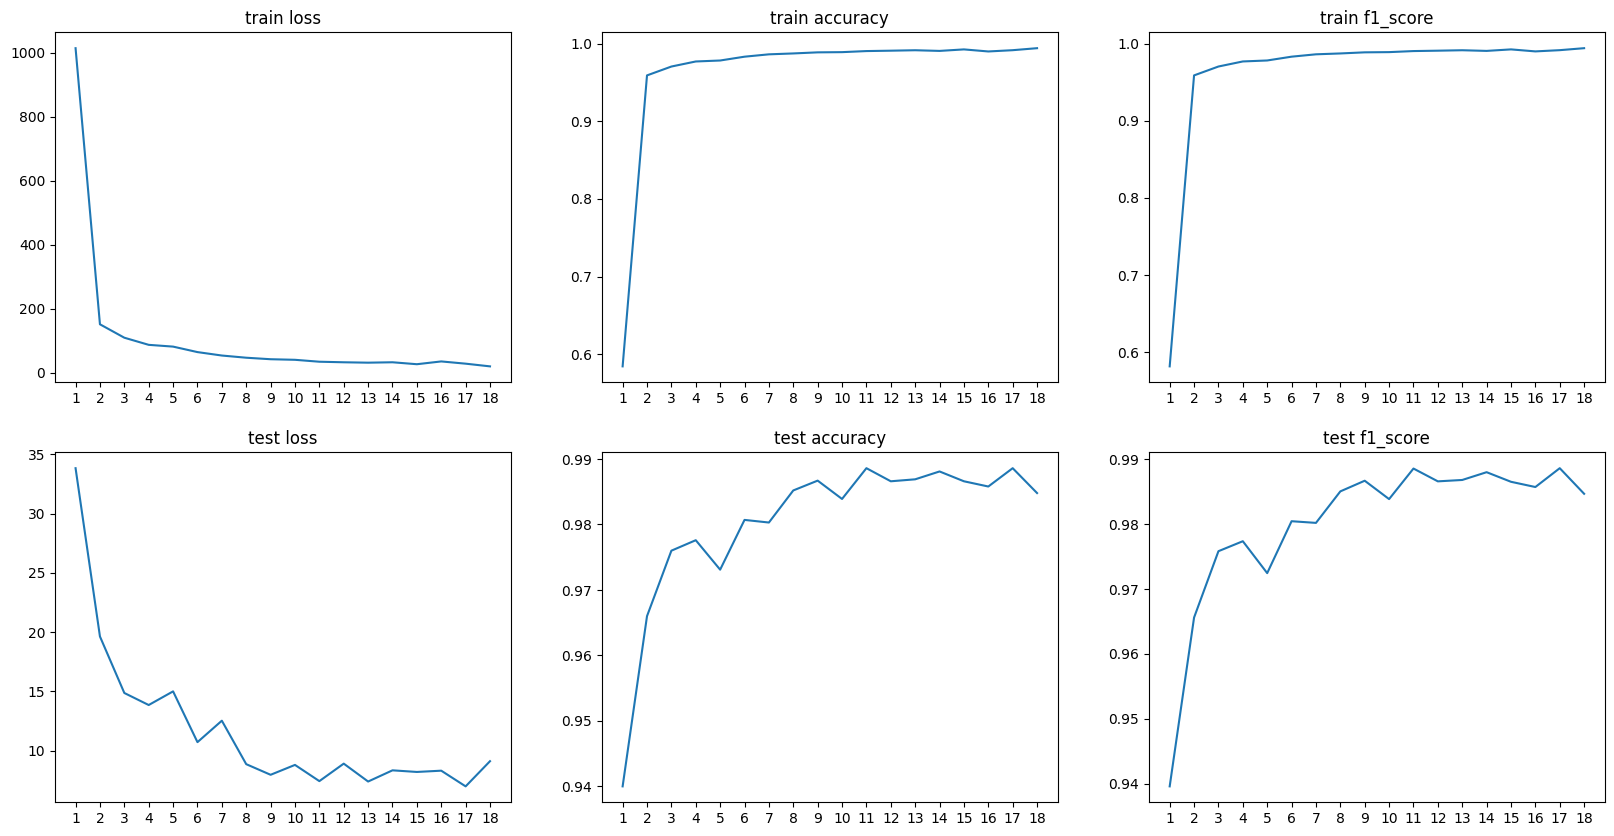

In [85]:
plot_history([epoch_history])

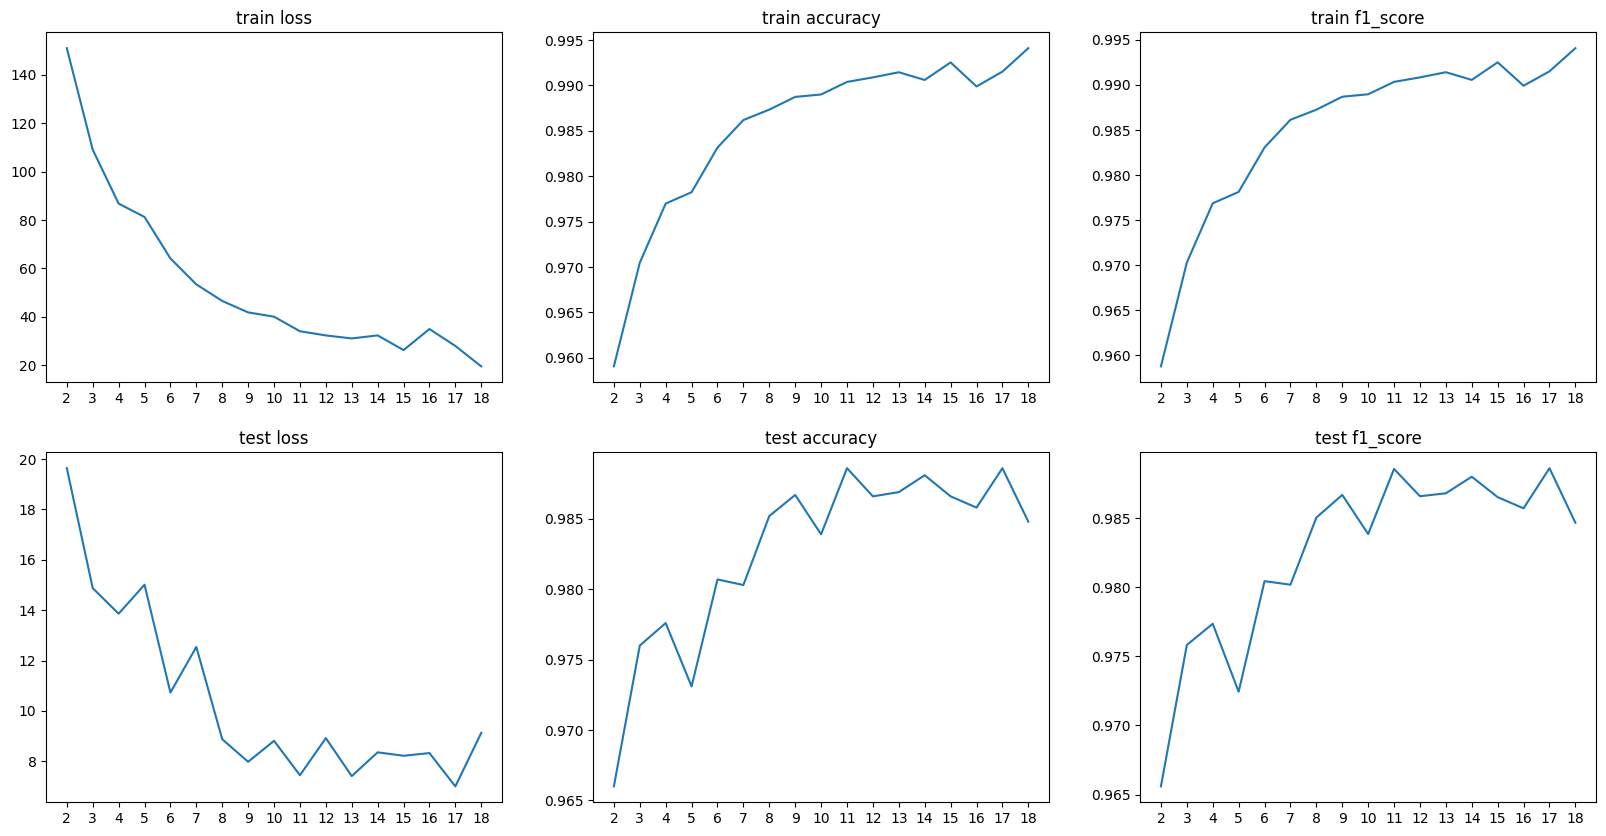

In [86]:
plot_history([epoch_history], omit_first_epoch = True)

In [19]:
for i in range(5):
    probs_i = softmax(model.forward(X_train[i].reshape(1, 1, 32, 32)))
    plt.title(f"true label: {np.argmax(y_train[i])}\n predicted label: {np.argmax(probs_i)}")
    plt.imshow(X_train[i].reshape(32, 32))
    plt.axis = 'off'
    plt.show()

AttributeError: 'MaxPool2d' object has no attribute '_use_neg_inf_for_padding'

In [20]:
for i in range(5):
    probs_i = softmax(model.forward(X_test[i].reshape(1, 1, 32, 32)))
    plt.title(f"true label: {np.argmax(y_test[i])}\n predicted label: {np.argmax(probs_i)}")
    plt.imshow(X_test[i].reshape(32, 32))
    plt.show()

AttributeError: 'MaxPool2d' object has no attribute '_use_neg_inf_for_padding'

In [25]:
import os
import pickle
from utils.plot import plot_history

def get_histories(trained_models_dir, folder_names, history_file_name):
    histories = []
    for folder_name in folder_names:
        history_path = os.path.join(trained_models_dir, folder_name, history_file_name)
        with open(history_path, 'rb') as f:
            history = pickle.load(f)
        histories.append(history)
    return histories
trained_models_dir = os.path.join(".", "numpy_nn", "models", "trained_models")

history_filename = "history_only.pickle"

folder_names = history_names = [
    "resnet101_without_batchnorm",
    "resnet101",
    "resnet101_with_bias_correction_of_batchnorm",
]

histories = get_histories(trained_models_dir, folder_names, history_filename)

In [23]:
print(histories[0]['test'])

{'loss': [23.503220935245515, 12.349643707957048, 12.580167280586629, 7.213566758341952, 10.263043085880343, 8.729003043323505, 8.250894770305399, 8.08733122428237, 6.89406861617335, 8.716279777606095, 10.21636839533039, 8.409411425410138, 7.855407238756466, 7.357807755578784, 6.452528759934651, 7.197519187680871, 11.0435817850185, 8.885024538460058, 8.19267724277026], 'accuracy': [0.9572, 0.9782, 0.9801, 0.9869, 0.9828, 0.9856, 0.987, 0.9871, 0.9896, 0.9864, 0.984, 0.9876, 0.9885, 0.9897, 0.9906, 0.9906, 0.9859, 0.9867, 0.9873], 'f1_score': [0.9565972216908702, 0.978242947869983, 0.9800076626106012, 0.9867961986961531, 0.982495078891245, 0.9855604221082818, 0.9868516879328268, 0.9870477568615046, 0.9895448029726375, 0.9862549541157533, 0.9838732843095878, 0.9875428826049693, 0.988459800666558, 0.989559235636491, 0.9905387496890097, 0.9905534281172186, 0.9858700660005875, 0.9866081596827458, 0.9871022875482653]}


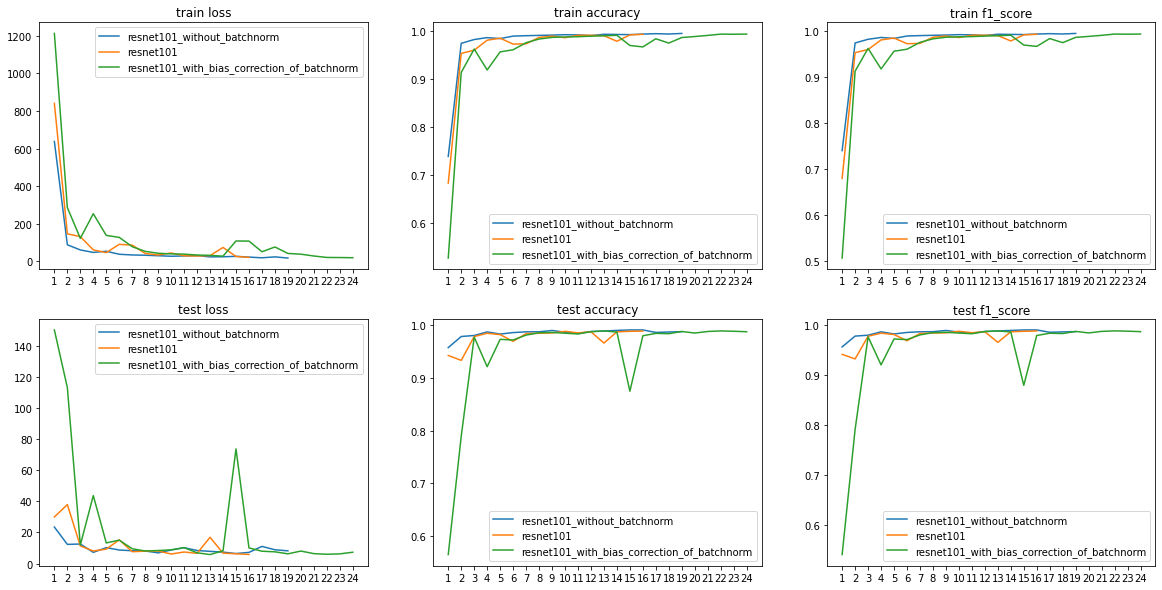

In [29]:
plot_history(histories, history_names)

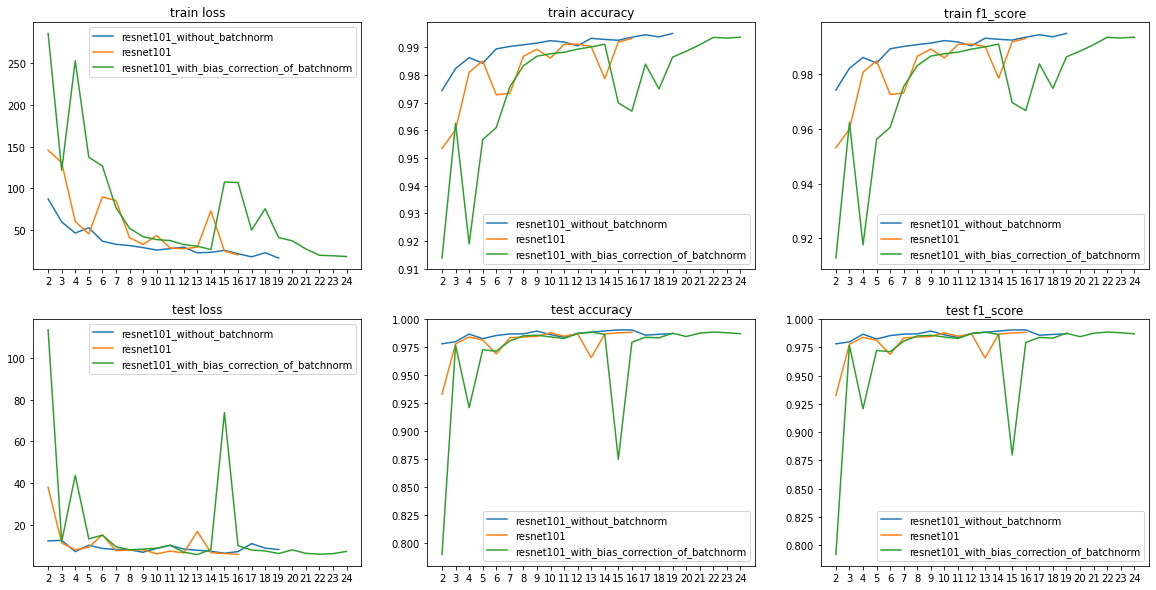

In [18]:
plot_history(histories, history_names, omit_first_epoch=True)

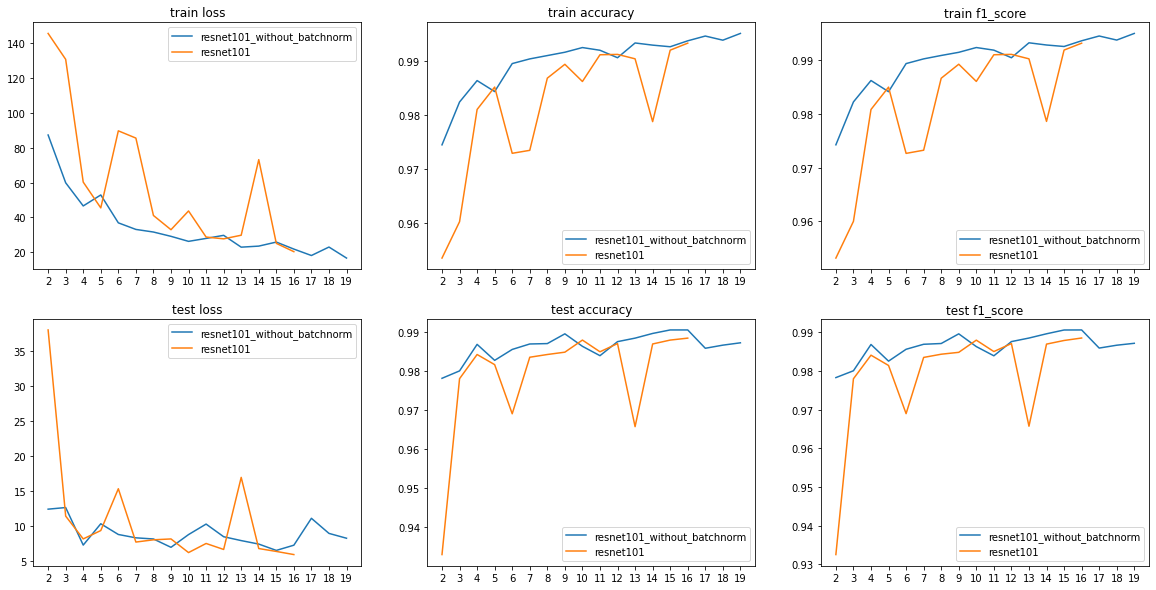

In [30]:
plot_history(histories[:2], history_names[:2], omit_first_epoch = True)

# Small CNN

In [ ]:
# _, in_channels, height, width, = X_train.shape
# out_channels = 32
# kernel_size = 3
# stride = 1
# padding = 1
# bias = True


# batch_size = 64
# epochs = 5
# weights_data = []

# model_small_cnn = Sequential([
#     Conv2d(in_channels, out_channels, kernel_size, stride, padding), ReLULayer(),
#     # Conv2d(out_channels, out_channels, kernel_size, stride, padding), ReLULayer(),
#     Flatten(), FullyConnectedLayer(height * width * out_channels, 10)])
# # optimizer = GradientDescentOptimizer(model.trainable_layers, learning_rate = 1e-3)
# optimizer_small_cnn = AdamOptimizer(model_small_cnn.trainable_layers, learning_rate = 1e-3)
# loss = CrossEntropyLossWithSoftMax()

# metric_names = ['loss', 'accuracy', 'f1_score']
# epoch_history_small_cnn = {phase_name: {metric_name: [] for metric_name in metric_names} for phase_name in ['train', 'test']}
# # epoch_history_small_cnn['experimant_name'] = 'small cnn'

# train(model_small_cnn, X_train, y_train, X_test, y_test, optimizer_small_cnn, loss, epochs, batch_size, epoch_history_small_cnn)

In [ ]:
# plot_history([epoch_history_small_cnn])

In [ ]:
# import torch

In [ ]:
# X_train_torch = torch.from_numpy(X_train).float()
# y_train_torch = torch.from_numpy(y_train)

# X_test_torch = torch.from_numpy(X_test).float()
# y_test_torch = torch.from_numpy(y_test)

# def train_torch(model, X_train: torch.Tensor, y_train: torch.Tensor, X_test: torch.Tensor, y_test: torch.Tensor,
#           optimizer, loss, epochs: int, batch_size: int):
    
#     metric_names = ['loss', 'accuracy', 'f1_score']
#     history = {phase_name: {metric_name: [] for metric_name in metric_names} for phase_name in ['train', 'test']}

#     for i in range(epochs):
#         for j in tqdm(range(0, X_train.shape[0], batch_size)):
#             # print(f"epoch {i} batch {j}")
#             X_b_train = X_train[j:j+batch_size]
#             y_b_train = y_train[j:j+batch_size]
#             y_pred = model(X_b_train)
#             loss_val = loss(y_pred, y_b_train)
#             optimizer.zero_grad()
#             loss_val.backward()
#             optimizer.step()

#             y_pred_label = np.argmax(y_pred.detach().numpy(), axis=1)
#             y_true_label = np.argmax(y_b_train.detach().numpy(), axis=1)

#             history['train']['accuracy'].append(np.mean(y_pred_label == y_true_label).item())
#             history['train']['loss'].append(loss_val.item())
#             history['train']['f1_score'].append(f1_score(y_true_label, y_pred_label, average='macro').item())
            
#     return history

In [ ]:
# in_channels = 1
# out_channels = 32
# kernel_size = 3
# stride = 1
# padding = 1
# bias = True

# height = X_train[0].shape[1]
# width = X_train[0].shape[2]

# batch_size = 1024
# epochs = 3

# model_torch = torch.nn.Sequential(
#     torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
#     torch.nn.ReLU(),
#     torch.nn.Flatten(), 
#     torch.nn.Linear(height * width * out_channels, 10),
# )

# weights_data_torch = []

# optimizer_torch = torch.optim.Adam(model_torch.parameters(), lr=1e-3)

# loss_torch = torch.nn.CrossEntropyLoss()

# history_torch = train_torch(model_torch, X_train_torch, y_train_torch, X_test_torch, y_test_torch, optimizer_torch, loss_torch, epochs, batch_size)

In [ ]:
# for key, value in history_torch['train'].items():
#     plt.plot(value)
#     plt.title(key)
#     plt.show()

In [ ]:
# print("cucu")